In [ ]:
!pip install python_speech_features
!pip install hmmlearn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
print ("Uncompressing zip file")
zip_ref = ZipFile('/content/drive/MyDrive/dataset/Commands Dataset-20200305T135856Z-001.zip')
zip_ref.extractall('Data/')
zip_ref.close()

Uncompressing zip file


In [ ]:
words = 'right up down yes no stop go left on off'.split()
for w in words:
  zip_ref = ZipFile('/content/Data/Commands Dataset/train/'+w+'.zip')
  zip_ref.extractall('TRAINING/')

In [ ]:
zip_ref = ZipFile('/content/Data/Commands Dataset/test_clean.zip')
zip_ref.extractall('Test/')

zip_ref = ZipFile('/content/Data/Commands Dataset/test_noisy.zip')
zip_ref.extractall('Test/')

### importing libraries and packages

In [ ]:
from __future__ import print_function
import warnings
import os
#from scikits.talkbox.features import mfcc
import librosa
from scipy.io import wavfile
from hmmlearn import hmm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from python_speech_features import mfcc,delta
import pickle
from sklearn.metrics import confusion_matrix
import itertools
warnings.filterwarnings('ignore')

###MFCC Calculation with endpointing and pre-emphasis

In [ ]:
def MFCC_CAL(audioname):
  #taking input
  str1 = audioname
  data , samplerate = librosa.load(str1,sr=None)
  #calculating the moving Average
  window_size = 100
  i = 0
  decimal_points = 7
  moving_averages = []
  while i < len(data) - window_size + 1:
    this_window = data[i : i + window_size]
    window_average = sum(this_window) / window_size
    moving_averages.append(window_average)
    i += 1

  #making the length of moving average signal to be equal to original signal length
  new_signal = np.zeros(len(data))
  new_signal[window_size-1:len(data)] = moving_averages

  #making a new signal from moving averaged signal multiplied by  energy of the signal at that point
  multiplied = new_signal*(data**2)

  #end-pointing
  end_point_min = 0
  for i in range(len(multiplied)):
    if (round(multiplied[i],decimal_points)>0):
      end_point_min = i
      break

  end_point_max = len(multiplied)-1
  for i in range(len(multiplied)-1,-1,-1):
    if (round(multiplied[i],decimal_points)>0):
      end_point_max = i
      break
  if (end_point_max - end_point_min>=0.08*len(data)):
    end_pointed_data = data[end_point_min:end_point_max]
  else:
    end_pointed_data = np.zeros(len(data))

  #MFCC Calculation
  mfccs = mfcc(end_pointed_data, samplerate=samplerate, winlen=0.02, winstep=0.01, numcep=13, nfilt=26, nfft=512, preemph=0.95)
  d_mfcc = delta(mfccs, 2)
  d_d_mfcc = delta(d_mfcc,2)
  vector = np.hstack((mfccs,d_mfcc,d_d_mfcc))
  return vector

###Building DATASET

In [ ]:
def buildDataSet(dir,w):
    # Filter out the wav audio files under the dir
    fileList = [f for f in os.listdir(dir) if os.path.splitext(f)[1] == '.wav']
    dataset = {}
    for fileName in fileList:
        #tmp = fileName.split('.')[0]
        label = w
        feature = MFCC_CAL(dir+fileName)
        if label not in dataset.keys():
            dataset[label] = []
            dataset[label].append(feature)
        else:
            exist_feature = dataset[label]
            exist_feature.append(feature)
            dataset[label] = exist_feature
    return dataset

###Training Model

In [ ]:
number_states= 7
epochs = 300
dimension=1

In [ ]:
def starting():
  startProbability = np.zeros(number_states)
  startProbability[0: dimension] = 1/float(dimension)
  return startProbability

In [ ]:
def transition():
  transition_mat = (1/float(dimension+1)) * np.eye(number_states)
  for i in range(number_states-dimension):
    for j in range(dimension):
      transition_mat[i,i+j+1] = 1.0/(dimension+1)
  j=0
  for i in range(number_states - dimension,number_states):
    for j in range(number_states-i-j):
      transition_mat[i,i+j] = 1.0/(number_states-i)

  return transition_mat

In [ ]:
from sklearn.cluster import KMeans
def train_GMMHMM(dataset,mixes,n):
    GMMHMM_Models = {}
    dimension = 1
    transmatPrior = transition()
    startprobPrior = starting()
    
    for label in dataset.keys():
        #model = hmm.GMMHMM(n_components=number_states,n_mix=mixes, transmat_prior=transmatPrior,startprob_prior=startprobPrior,covariance_type='full', n_iter=epochs)
        model = KMeans(n_clusters=n,random_state = 42,max_iter=500)
        trainData = dataset[label]
        length = np.zeros([len(trainData), ], dtype=np.int)
        for m in range(len(trainData)):
            length[m] = trainData[m].shape[0]
        trainData = np.vstack(trainData)
        model.fit(trainData)  # get optimal parameters
        GMMHMM_Models[label] = model
    return GMMHMM_Models

###MAIN CODE

In [ ]:
# Running this would take almost 6 hours, so do it if necessary only
words = 'down up right left go stop no yes on off'.split()
trainDataSet = {}
for w in words:
  trainDir = '/content/TRAINING/'+w+'/'
  trainDataSet.update(buildDataSet(trainDir,w))
  print("Finished preparing the training data for : " + w)
  file = open('/content/drive/MyDrive/dataset/'+'traindata_'+w,'wb')
  pickle.dump(trainDataSet,file)
  file.close()

testDataSet_clean = {}
for w in words:
  testDir_clean = '/content/Test/test_clean/'+w+'/'
  testDataSet_clean.update(buildDataSet(testDir_clean,w))
  print("Finished preparing the testing clean data for : " + w)
  file = open('/content/drive/MyDrive/dataset/'+'test_clean_data_'+w,'wb')
  pickle.dump(testDataSet_clean,file)
  file.close()

In [ ]:
#file = open('/content/drive/MyDrive/dataset/train_data','rb')
file = open('/content/drive/MyDrive/train_data','rb')
trainDataSet = pickle.load(file)
file.close()

#file = open('/content/drive/MyDrive/dataset/test_clean_data','rb')
file = open('/content/drive/MyDrive/test_clean_data','rb')
testDataSet_clean = pickle.load(file)
file.close()

#file = open('/content/drive/MyDrive/dataset/test_noisy_data','rb')
file = open('/content/drive/MyDrive/test_noisy_data','rb')
testDataSet_noisy = pickle.load(file)
file.close()

In [ ]:
words = 'down up right left go stop no yes on off'.split()
testDataSet_noisy = {}
for w in words:
  testDir_noisy = '/content/Test/test_noisy/'+w+'/'
  testDataSet_noisy.update(buildDataSet(testDir_noisy,w))
  print("Finished preparing the testing noisy data for : " + w)
  file = open('/content/drive/MyDrive/dataset/'+'test_noisy_data_'+w,'wb')
  pickle.dump(testDataSet_noisy,file)
  file.close()

Finished preparing the testing noisy data for : down
Finished preparing the testing noisy data for : up
Finished preparing the testing noisy data for : right
Finished preparing the testing noisy data for : left
Finished preparing the testing noisy data for : go
Finished preparing the testing noisy data for : stop
Finished preparing the testing noisy data for : no
Finished preparing the testing noisy data for : yes
Finished preparing the testing noisy data for : on
Finished preparing the testing noisy data for : off


In [ ]:
import random
data = {}
for key in trainDataSet.keys():
  data[key]=random.choices(trainDataSet[key],k=2500)

hmmModels = train_GMMHMM(data,3,5)
acc,success,predicted_label,real_labels=do_testing(testDataSet_clean))


0.631


###Testing

####clean data testing

In [ ]:
#clean data testing
def do_testing(testDataSet_clean):
  success = 0
  predicted_label = []
  real_labels = []
  testclean =[]
  total =0
  label = []
  testD = '/content/Test/test_clean'
  word=0

  testdataset_clean = {}
  for key in testDataSet_clean.keys():
    testdataset_clean[key]=random.choices(testDataSet_clean[key],k=250)

  for f in testdataset_clean.keys():
    for w in testdataset_clean[f]:
      feature = w
      if len(feature)!=0:
        probs = {}
        for label in hmmModels:
          model = hmmModels[label]
          probs[label] = model.score(feature)
        result = max(probs,key = probs.get)
        predicted_label.append(result)
        real_labels.append(f)
      if (result == f):
        success += 1
      
    #print(f'testing {f} is done')
  Accuracy=(success/len(real_labels))
  return(Accuracy,success,predicted_label,real_labels)

Accuracy: 0.6184


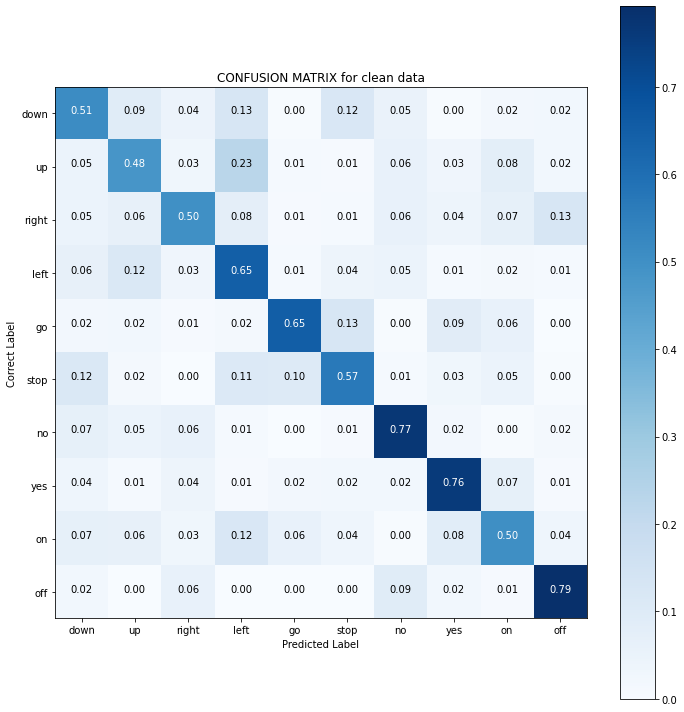

<Figure size 432x288 with 0 Axes>

In [ ]:
acc,success,predicted_label,real_labels=do_testing(testDataSet_clean)
different_words = testdataset_clean.keys()

#plotting Confusion Matrix for clean data
conf_mat1 = confusion_matrix(real_labels,predicted_label)
conf_mat1 = conf_mat1.astype('float')/conf_mat1.sum(axis=1)[:,np.newaxis]
#print(conf_mat1)

print("Accuracy: "+str(acc))
plt.figure(figsize=(10,10))
plt.imshow(conf_mat1,cmap=plt.cm.Blues)
plt.colorbar(cmap='Blues')
plt.title('CONFUSION MATRIX for clean data')
plt.xticks(range(len(different_words)),different_words,rotation=0.60)
plt.yticks(range(len(different_words)),different_words)

for i,j in itertools.product(range(conf_mat1.shape[0]),range(conf_mat1.shape[1])):
  plt.text(j,i,format(conf_mat1[i,j], '.2f'), horizontalalignment = "center",color="white" if i==j else "black")

plt.tight_layout()
plt.ylabel('Correct Label')
plt.xlabel('Predicted Label')
plt.show()
plt.savefig("clean.png")

####noisy data testing

In [ ]:
#noisy data testing

success_n = 0
predicted_label_n = []
real_labels_n = []
testnoisy =[]
total_n =0
testD_n = '/content/Test/test_noisy'
word=0

for f in testDataSet_noisy.keys():
  for w in testDataSet_noisy[f]:
    feature = w
    if len(feature)!=0:
      probs = {}
      for label in hmmModels:
        model = hmmModels[label]
        probs[label] = model.score(feature)
      result_n = max(probs,key = probs.get)
      predicted_label_n.append(result_n)
      real_labels_n.append(f)
    if (result_n == f):
      success_n += 1
    else:
      pass
  print(f'testing {f} is done')

testing down is done
testing up is done
testing right is done
testing left is done
testing go is done
testing stop is done
testing no is done
testing yes is done
testing on is done
testing off is done


Accuracy is : 0.4632


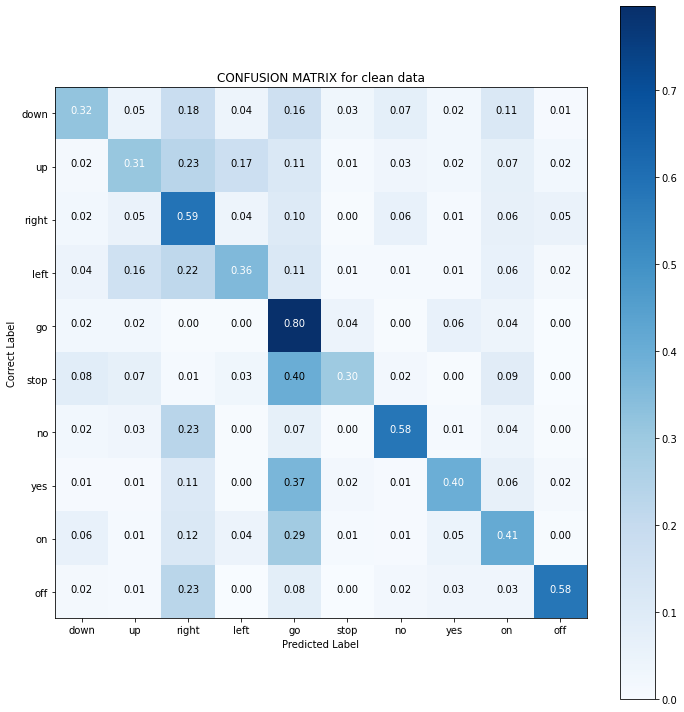

<Figure size 432x288 with 0 Axes>

In [ ]:
acc,success_n,predicted_label_n,real_labels_n=do_testing(testDataSet_noisy)
different_words = testDataSet_noisy.keys()

#plotting Confusion Matrix for clean data
conf_mat2 = confusion_matrix(real_labels_n,predicted_label_n)
conf_mat2 = conf_mat2.astype('float')/conf_mat2.sum(axis=1)[:,np.newaxis]
#print(conf_mat1)

print('Accuracy is : '+str(acc))
plt.figure(figsize=(10,10))
plt.imshow(conf_mat2,cmap=plt.cm.Blues)
plt.colorbar(cmap='Blues')
plt.title('CONFUSION MATRIX for clean data')
plt.xticks(range(len(different_words)),different_words,rotation=0.60)
plt.yticks(range(len(different_words)),different_words)

for i,j in itertools.product(range(conf_mat2.shape[0]),range(conf_mat2.shape[1])):
  plt.text(j,i,format(conf_mat2[i,j], '.2f'), horizontalalignment = "center",color="white" if i==j else "black")

plt.tight_layout()
plt.ylabel('Correct Label')
plt.xlabel('Predicted Label')
plt.show()
plt.savefig("noisy.png")

In [ ]:
import random
test_dict = {"up":[[1,2,3],[123,23],[323,123]],"down":[[1,2,3],[123,23],[323,123]]}
for key in test_dict.keys():
  print(random.choices(test_dict[key],k=1))

[[123, 23]]
[[323, 123]]
